In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from IPython.display import Image
from qutip import *
from math import sqrt
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema, find_peaks
from lmfit import Parameters,minimize, fit_report

The single qubit simulation will use system constants from this paper by Majer et al.: https://www.nature.com/articles/nature06184. The Qutip notebook the code is derived from can be found at: https://nbviewer.ipython.org/github/qutip/qutip-notebooks/blob/master/examples/rabi-oscillations.ipynb.
\\
This simulation makes use of the Tavis-Cummings Hamiltonian: \\
$$\hat{H}/\hbar = \omega_c\hat{a}^{†}a + \sum_{i=1}^{N} \frac{1}{2}\omega_{qi}\hat{\sigma}_z + \frac{1}{2}g_{i}(\hat{a}\hat{\sigma}^{+}_{i} + \hat{a}^{†}\hat{\sigma}^{-}_{i})$$

### Setting the system constants
All constant in units of GHz, the set values are from Majer. Time is in units of nanoseconds.

In [51]:
wq1 = 5.19  * 2* np.pi # 6.617 * GHz * 2* np.pi # wq = sqrt(8EjEc)
wq2 = 5.19 * 2* np.pi # 2.88 * GHz * 2* np.pi # 6.529 * GHz * 2* np.pi
wc = 5.19 * 2* np.pi # 5.19 * GHz * 2 * np.pi, 3 works
g1 = 0.105 * 2 * np.pi # 0.105 * GHz * 2 * np.pi
g2 = 0.105 * 2 * np.pi # g1
N = 20 # numberof qubit fock states considered
# cavity dissapation rate
kappa = 0.0033 * 2 * np.pi
# qubit dissapation rate
gamma1 = 0.00261 * 2* np.pi
gamma2 = gamma1

use_rwa = False 
n1 = 1 # number photons starting in qubit 1 
n2 = 0 # number photons starting in qubit 2
# times to evolve over
tlist = np.linspace(0, 18, 10000)

#### Time dependent Hamiltonian term
Paper by Yang et al.: https://arxiv.org/pdf/1810.00652.pdf 
Yang et al. finds a time dependent frequency drift in the hybridized energy levels of the qubits-cavity system. As a result the cavity doesn't change frequency while the qubits do, so detuning gets larger. We correct for this by adding a drift factor to the cavity frequency - this is $\frac{g^{2}_{i}}{\Delta(t)}$. 

In [52]:

# create drift factor for cavity frequency
if (wc-wq1) != 0 and (wc-wq2) != 0:
    dwc = g1**2/(wc-wq1)**2 + g2**2/(wc-wq2)**2
else:
    dwc = 0
    
def wc_dep(t,args):
    return wc + dwc

### Operators and Hamiltonian
The destroy() and qeye() matrices are default Fock basis, with the specified size. The model we are assuming has cavity-qubit-qubit for indicies

In [53]:
# cavity operators
a = tensor(destroy(N), qeye(2), qeye(2))
nc = a.dag()*a

# qubit 1 operators
sm1 = tensor(qeye(N), destroy(2), qeye(2))
sz1 = tensor(qeye(N), sigmaz(), qeye(2))
nq1 = sm1.dag() * sm1

# qubit 2 operators 
sm2 = tensor(qeye(N), qeye(2), destroy(2))
sz2 = tensor(qeye(N), qeye(2), sigmaz())
nq2 = sm2.dag() * sm2

# Control Hamiltionians for each system
Hc = nc
Hq1 = -0.5 * sz1 * wq1
Hq2 = -0.5 * sz2 * wq2
if use_rwa:
    Hc1 = g1 * (a.dag()*sm1 + a*sm1.dag())
    Hc2 = g2 * (a.dag()*sm2 + a*sm2.dag())
else:
    Hc1 = g1 * (a.dag() + a)*(sm1 + sm1.dag())
    Hc2 = g2 * (a.dag() + a)*(sm2 + sm2.dag())

H = [[Hc, wc_dep], Hq1, Hq2, Hc1, Hc2]

### Calculate the Theoretical Rabi Frequency
We can calculate the Rabi frequency for the Tavis-Cummings model to compare the simulation value to later. The general equation is: $$\Omega_i = \sqrt{4Ng^{2}_{i} + \Delta^{2}_{i}}$$ for the ith qubit of N qubits

In [54]:
if abs(wq1-wc) == abs(wq2-wc): #and (abs(wq1-wc) == abs(wq2-wc)):
    r1 = sqrt(2*4*(g1**2)*(n1 + 1) + (wq1-wc)**2)
    r2 = sqrt(2*4*(g2**2)*(n2 + 1) + (wq2-wc)**2)
else:
    print("Rabi frequency prediction is inaccurate")
    r1 = 0
    r2 = 0
print(f"qubit 1 rabi frequency {r1} GHz, qubit 2 rabi frequency {r2} GHz")

qubit 1 rabi frequency 2.638937829015426 GHz, qubit 2 rabi frequency 1.8660108340265136 GHz


### Time Evolution of the System
First we place quanta in one qubit excited state, with the cavity remaining in ground state. We define the collapse operators to add noise to our system. We specify expectation values we are interested in finding - namely the number of quanta in the qubit and the number of quanta in the cavity.

In [55]:
# create dissapation operators list
collapse_ops = [sqrt(kappa) * a, sqrt(gamma1) * sm1, sqrt(gamma2) * sm2] 
# put qubit in excited state to start 
psi0 = tensor(basis(N,0), basis(2,n1), basis(2,n2))
# make the system evolve 
output = mesolve(H, psi0, tlist, collapse_ops, [nc, nq1, nq2])

### Graphing the Output
Now we can graph the output expectation values according to the system evolution. First we do this without fitting:

Text(0.5, 1.0, 'Vacuum Rabi oscillations')

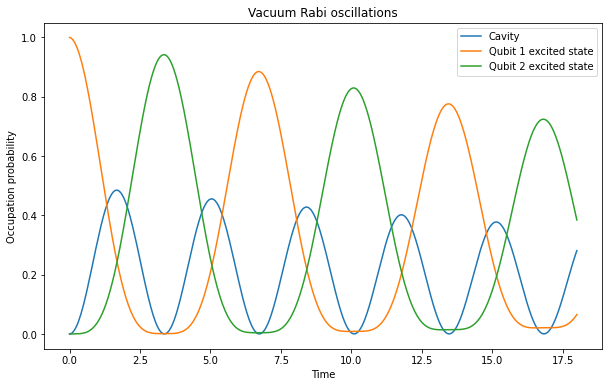

In [56]:
# expectation for number of quanta in cavity over tlist
n_c = output.expect[0]
# same for qubit 1
n_q1 = output.expect[1]
# same for qubit 2
n_q2 = output.expect[2]

# create the figure + plot the results
fig, axes = plt.subplots(1, 1, figsize=(10,6))
axes.plot(tlist, n_c, label="Cavity")
axes.plot(tlist, n_q1, label="Qubit 1 excited state")
axes.plot(tlist, n_q2, label="Qubit 2 excited state")
axes.legend(loc=0)
axes.set_xlabel('Time')
axes.set_ylabel('Occupation probability')
axes.set_title('Vacuum Rabi oscillations')

#### Adding the fit function
We can now fit a curve and get the simulated Rabi frequency. This requires a few helper functions.

In [59]:
def time_for_val(times, output, outputs):
    """
    returns: the time (or x val) at which a desired output occurs
    params: times - list of x values
        output - the output of interest to match x value to
        outputs - the total list of outputs
    """
    # the margin that values should be in to get result
    val_range = 0.01
    # first find the desired output in the outputs list
    out_idxL = np.where(abs(outputs-output) <= val_range)
    timesL = times[out_idxL]
    
    #trim so that it only includes time values that are notably different
    timesL = np.array(timesL)
    timesL = np.around(timesL, 9) # since we are in the GHz range we want the same order of accuracy
    timesL = np.unique(timesL)
    return timesL


def freq_guesser(data):
    """
    returns: frequency of periodic behaviour for input data set
    params: data - numpy array of data to be processed
    warnings: local maxima must be distinct / more than two or
            error will be thrown
    """
    if np.size(data) == 0:
        return 0
    else:
        peak_ind = find_peaks(data)[0]
        T = tlist[peak_ind[1]] - tlist[peak_ind[0]]
        freq=1/T
        return freq
    
    
def init_guesser(data, tlist):
    """
    returns: the approximate dataset params to be fed into curve_fit function
    params: dataset - numpy array of the data to be processed
            tlist - the times (x values) the data iterates over
    """
    # amplitude of sinusoid
    amp = (max(data) - min(data))/2
    # frequency of sinusoid
    freq = freq_guesser(data)
    # phase shift of sinusoid 
    phase = 0
    # vertical shift of sinusoid
    shift = amp + min(data) 
    
    
    peak_ind = find_peaks(data)[0] # get np.array in a tuple of the local maxima indices of the qubit
    if kappa==0 and gamma1 ==0 and gamma2 ==0:
        return amp, freq, phase, shift
    else:
        # exponential damping of sinusoid due to dissipation 
        damp = -(np.log(data[peak_ind[0]]))/(tlist[peak_ind[0]])
        damp = 1
        return amp, freq, phase, shift, damp


def get_fit(init_guess, data):
    """
    returns: the fit function for some given initial guess
    params: init_guess - [amp,freq,phase,shift,damp] where damping is
                        added when there is dissipation
    """
    if kappa==0 and gamma1==0 and gamma2 == 0:
        def init_func(t, amp, freq, phase, shift):
            return amp*(np.sin(freq*t + phase))**2 + shift

        param, param_cov = curve_fit(init_func, tlist, data, maxfev=50000, p0=init_guess)
        fit_func = param[0]*((np.sin(param[1]*tlist + param[2]))**2) + param[3]
    else:
        def init_func(t, amp, freq, phase, shift, damp):
            return amp*np.exp(-damp*t)*(np.sin(freq*t + phase))**2 + shift

        param, param_cov = curve_fit(init_func, tlist, data, maxfev=50000, p0=init_guess)
        fit_func = param[0]*np.exp(-param[4]*tlist)*((np.sin(param[1]*tlist + param[2]))**2) + param[3]
    return param, fit_func

Text(0.5, 1.0, 'Vacuum Rabi oscillations Qubit 2 and Cavity')

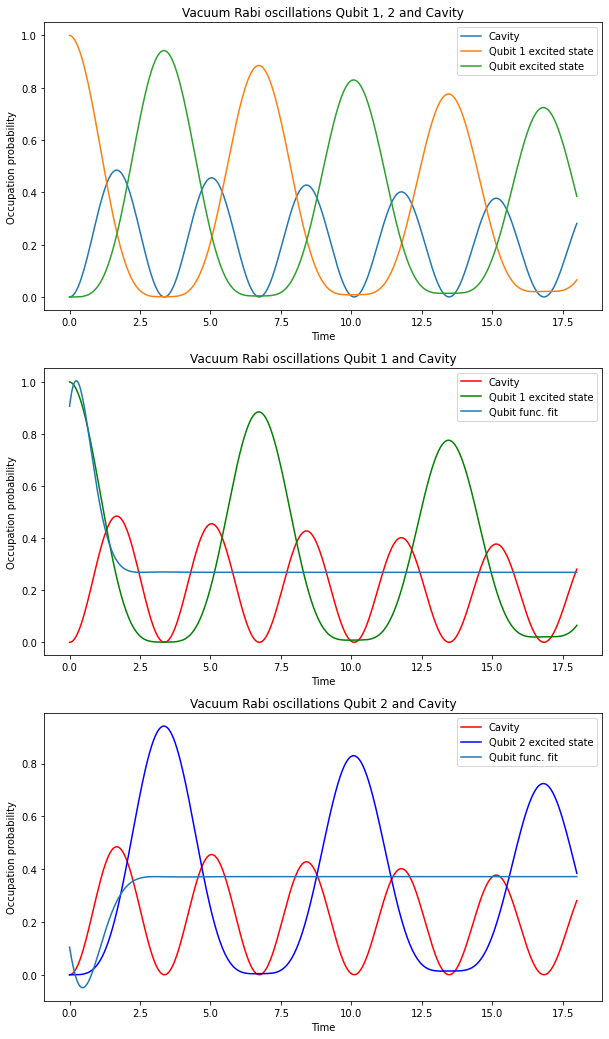

In [60]:
init_guess1 = init_guesser(n_q1,tlist)
param1, fit_func1 = get_fit(init_guess1, n_q1)
rabi_fit_f1 = abs(2*param1[1])

init_guess2 = init_guesser(n_q2,tlist)
param2, fit_func2 = get_fit(init_guess2, n_q2)
rabi_fit_f2 = abs(2*param2[1])


fig, axes = plt.subplots(3, 1, sharex=False, figsize=(10,18))
# oscillations with both qubits and cavity
axes[0].plot(tlist, n_c, label="Cavity")
axes[0].plot(tlist, n_q1, label="Qubit 1 excited state")
axes[0].plot(tlist, n_q2, label="Qubit excited state")
axes[0].legend(loc=0)
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Occupation probability')
axes[0].set_title('Vacuum Rabi oscillations Qubit 1, 2 and Cavity')

# Oscillations with q1 and cavity
axes[1].plot(tlist, n_c, 'r', label="Cavity")
axes[1].plot(tlist, n_q1, 'g', label="Qubit 1 excited state")
axes[1].plot(tlist, fit_func1, label="Qubit func. fit")
axes[1].legend(loc=0)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Occupation probability')
axes[1].set_title('Vacuum Rabi oscillations Qubit 1 and Cavity')

# Oscillations with q2 and cavity
axes[2].plot(tlist, n_c, 'r', label="Cavity")
axes[2].plot(tlist, n_q2, 'b',  label="Qubit 2 excited state")
axes[2].plot(tlist, fit_func2, label="Qubit func. fit")
axes[2].legend(loc=0)
axes[2].set_xlabel('Time')
axes[2].set_ylabel('Occupation probability')
axes[2].set_title('Vacuum Rabi oscillations Qubit 2 and Cavity')